In [1]:
import collections
import json
import datetime
import squarify
import dacite
import matplotlib.pyplot as plt
from src.config import get_config
from src.domain import CrossChainMevExtraction
from src.domain import PolygonBridgeInteraction
from src.blockchains.ethereum import EthereumService
from src.blockchains.polygon import PolygonService
file_path = 'extractions_result-18500000-19500000.json'

def json_to_cross_chain_mev_extraction_object(
        data: dict) -> CrossChainMevExtraction:
    return dacite.from_dict(
        data_class=CrossChainMevExtraction, data=data,
        config=dacite.Config(cast=[PolygonBridgeInteraction]))


def load_cross_chain_mev_extractions_from_file(
        file_path: str) -> list[CrossChainMevExtraction]:
    with open(file_path, 'r') as file:
        data_list = json.load(file)
    cross_chain_mev_extractions = []
    for data in data_list:
        try:
            cross_chain_mev_extractions.append(
                json_to_cross_chain_mev_extraction_object(data))
        except Exception:
            pass
    return cross_chain_mev_extractions



config = get_config()
ethereum_service = EthereumService(get_config()['URL']['ethereum'])
polygon_service = PolygonService(get_config()['URL']['polygon'])
cross_chain_mev_extractions = load_cross_chain_mev_extractions_from_file(
    file_path)
cyclic_arbs = [
    extraction for extraction in cross_chain_mev_extractions
    if extraction.is_cyclic_arbitrage
]

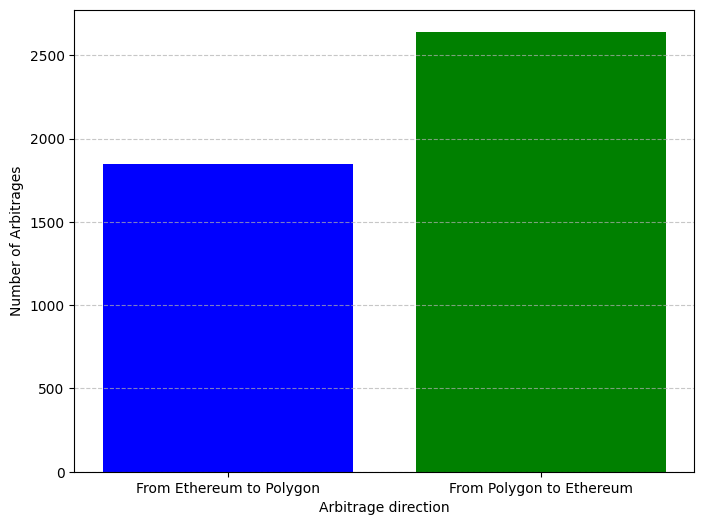

In [2]:
direction_counter = collections.Counter(
    extraction.direction for extraction in cross_chain_mev_extractions)
directions = ['From Ethereum to Polygon', 'From Polygon to Ethereum']
number_of_arbitrages = [direction_counter[1], direction_counter[2]]
plt.figure(figsize=(8, 6))
plt.bar(directions, number_of_arbitrages, color=['blue', 'green'])
plt.xlabel('Arbitrage direction')
plt.ylabel('Number of Arbitrages')
# plt.title('Cross-chain Arbitrage Directions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('number_of_arbitrages.png')
plt.show()

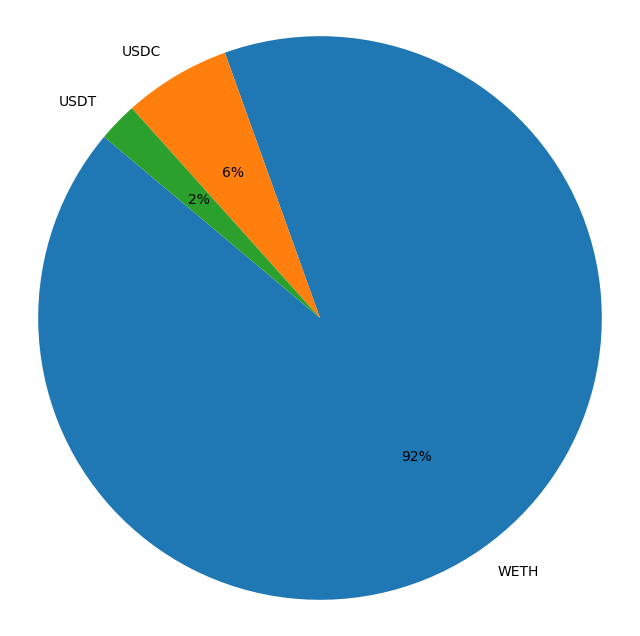

In [3]:
counter = collections.Counter(extraction.profit_token_symbol
                              for extraction in cyclic_arbs)
tokens = list(counter.keys())
usage_counts = list(counter.values())
plt.figure(figsize=(8, 8))  # Set the figure size (optional)
plt.pie(usage_counts, labels=tokens, autopct='%1.0f%%', startangle=140)
# plt.title('Token Usage for Arbitraging')
plt.axis('equal')
plt.savefig('profit_token.png')
plt.show()

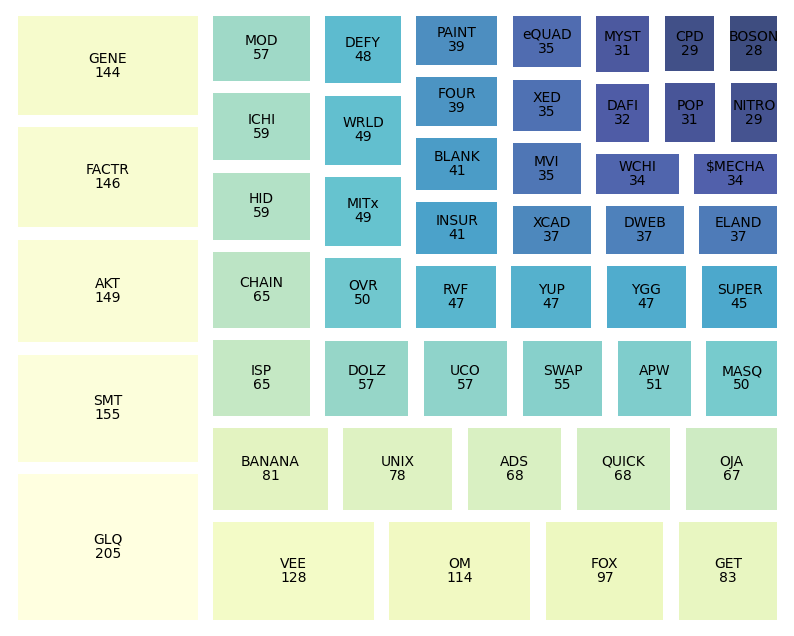

In [4]:
counter = collections.Counter(
    extraction.ethereum_leg.token_address
    for extraction in cross_chain_mev_extractions).most_common(50)
dict_counter = dict(counter)
new_dict = {}
for key in dict_counter:
    token_symbol = ethereum_service.get_token_symbol_and_parsed_amount(key,
                                                                       0)[0]
    new_dict[token_symbol] = dict_counter[key]
labels = list(new_dict.keys())
sizes = list(new_dict.values())

# Create a color gradient from yellow (highest) to purple (lowest)
max_size = max(dict_counter.values())
min_size = min(dict_counter.values())
colors = [plt.cm.YlGnBu(i / len(dict_counter)) for i in range(len(dict_counter))]
color_values = [(size - min_size) / (max_size - min_size) for size in sizes]

plt.figure(figsize=(10, 8))  # Adjust the figure size if needed
squarify.plot(sizes=sizes, label=labels, value=sizes, color=colors, pad=True, alpha=0.8)
# plt.title('Token Frequency Treemap')
plt.axis('off')  # Hide axis
plt.savefig('bridged_tokens.png')
plt.show()

Counter({1: 1833, 2: 13})
Counter({1: 2298, 2: 344})


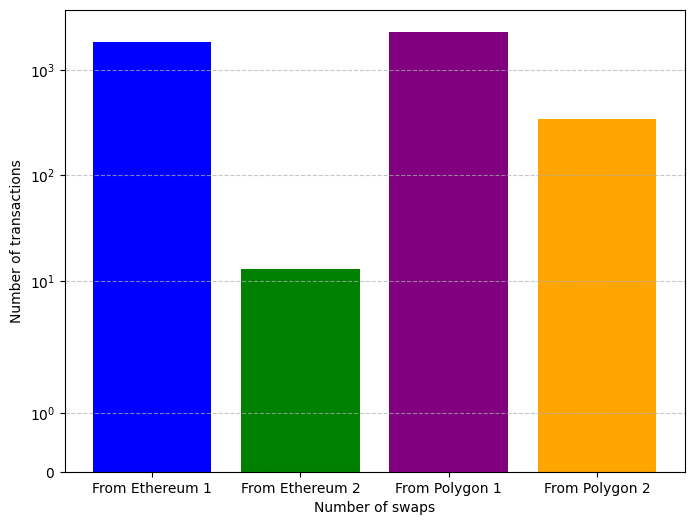

In [5]:
counter_from_ethereum = collections.Counter(
    len(extraction.ethereum_leg.swaps)
    for extraction in cross_chain_mev_extractions
    if extraction.direction is PolygonBridgeInteraction.FROM_ETHEREUM)
counter_to_ethereum = collections.Counter(
    len(extraction.ethereum_leg.swaps)
    for extraction in cross_chain_mev_extractions
    if extraction.direction is PolygonBridgeInteraction.TO_ETHEREUM)
print(counter_from_ethereum)
print(counter_to_ethereum)
plt.figure(figsize=(8, 6))
plt.bar([
    f'From Ethereum {str(key)}'
    for key in counter_from_ethereum.keys()
] + [
    f'From Polygon {str(key)}'
    for key in counter_to_ethereum.keys()
],
    list(counter_from_ethereum.values()) +
    list(counter_to_ethereum.values()),
    color=['blue', 'green', 'purple', 'orange'])
plt.xlabel('Number of swaps')
plt.ylabel('Number of transactions')
# plt.title('Number of swaps for ethereum swap leg')
plt.yscale('symlog')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('number_of_swaps_ethereum.png')
plt.show()

Counter({1: 1015, 2: 830})
Counter({1: 1419, 2: 1223})


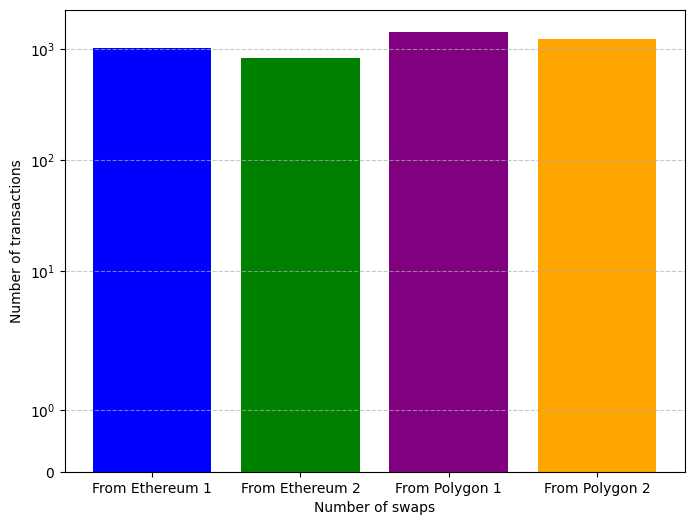

In [6]:
counter_from_ethereum = collections.Counter(
    len(extraction.polygon_leg.swaps)
    for extraction in cross_chain_mev_extractions
    if extraction.direction is PolygonBridgeInteraction.FROM_ETHEREUM)
del counter_from_ethereum[3]
counter_to_ethereum = collections.Counter(
    len(extraction.polygon_leg.swaps)
    for extraction in cross_chain_mev_extractions
    if extraction.direction is PolygonBridgeInteraction.TO_ETHEREUM)
print(counter_from_ethereum)
print(counter_to_ethereum)
plt.figure(figsize=(8, 6))
plt.bar([
    f'From Ethereum {str(key)}'
    for key in counter_from_ethereum.keys()
] + [
    f'From Polygon {str(key)}'
    for key in counter_to_ethereum.keys()
],
    list(counter_from_ethereum.values()) +
    list(counter_to_ethereum.values()),
    color=['blue', 'green', 'purple', 'orange'])
plt.xlabel('Number of swaps')
plt.ylabel('Number of transactions')
# plt.title('Number of swaps for polygon swap leg')
plt.yscale('symlog')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('number_of_swaps_polygon.png')
plt.show()

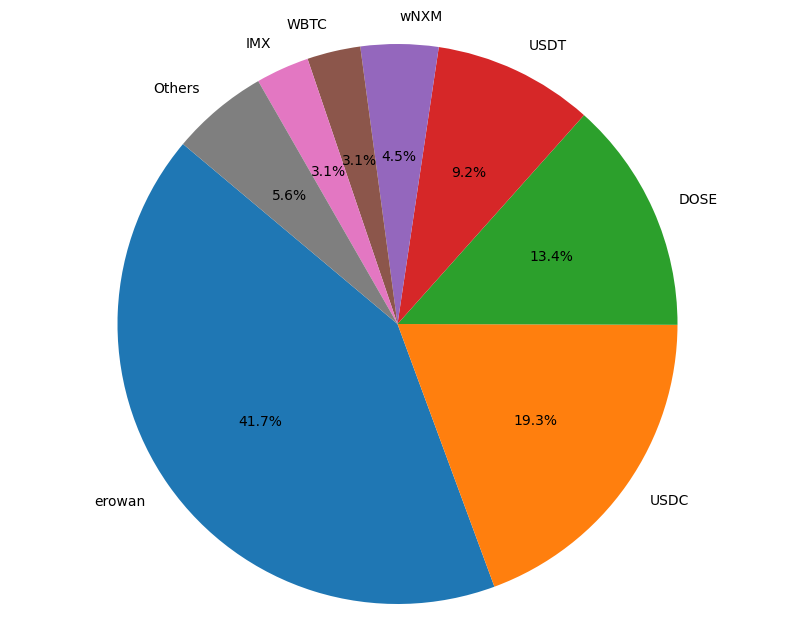

In [7]:
token_counter_ethereum = collections.defaultdict(lambda: 0)
threshold = 7
for extraction in cross_chain_mev_extractions:
    if len(extraction.ethereum_leg.swaps) > 1:
        for swap in extraction.ethereum_leg.swaps[:-1]:
            token_counter_ethereum[swap.token_out] += 1
token_counter_symbol_dict_ethereum = {}
for token in token_counter_ethereum:
    token_counter_symbol_dict_ethereum[
        ethereum_service.get_token_symbol_and_parsed_amount(
            token, 0)[0]] = token_counter_ethereum[token]
sorted_tokens = sorted(token_counter_symbol_dict_ethereum.items(), key=lambda x: x[1], reverse=True)
tokens = [token for token, _ in sorted_tokens]
counts = [count for _, count in sorted_tokens]
if len(tokens) > threshold:
    other_count = sum(count for count in counts[threshold:])
    tokens = tokens[:threshold] + ['Others']
    counts = counts[:threshold] + [other_count]
# Create pie chart
plt.figure(figsize=(10, 8))
plt.pie(counts, labels=tokens, autopct='%1.1f%%', startangle=140)
# plt.title('Token Usage in Arbitrage Intermediaries On Ethereum')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('intermiedary_tokens_ethereum.png')
plt.show()

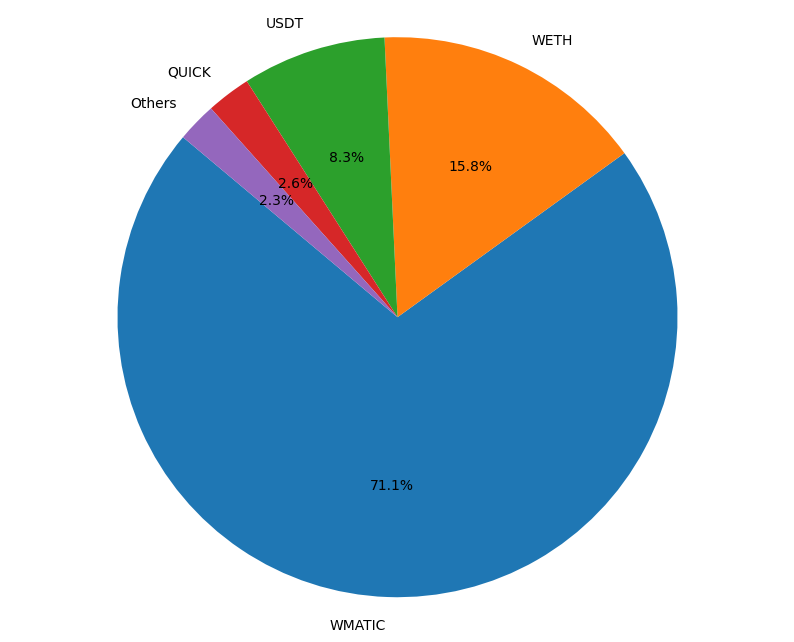

In [8]:
token_counter_polygon = collections.defaultdict(lambda: 0)
for extraction in cross_chain_mev_extractions:
    if len(extraction.polygon_leg.swaps) > 1:
        for swap in extraction.polygon_leg.swaps[:-1]:
            token_counter_polygon[swap.token_out] += 1
token_counter_symbol_dict_polygon = {}
for token in token_counter_polygon:
    token_counter_symbol_dict_polygon[
        polygon_service.get_token_symbol_and_parsed_amount(
            token, 0)[0]] = token_counter_polygon[token]
sorted_tokens = sorted(token_counter_symbol_dict_polygon.items(), key=lambda x: x[1], reverse=True)
threshold = 4
tokens = [token for token, _ in sorted_tokens]
counts = [count for _, count in sorted_tokens]
if len(tokens) > threshold:
    other_count = sum(count for count in counts[threshold:])
    tokens = tokens[:threshold] + ['Others']
    counts = counts[:threshold] + [other_count]
plt.figure(figsize=(10, 8))
plt.pie(counts, labels=tokens, autopct='%1.1f%%', startangle=140)
# plt.title('Token Usage in Arbitrage Intermediaries On Polygon')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('intermiedary_tokens_polygon.png')
plt.show()

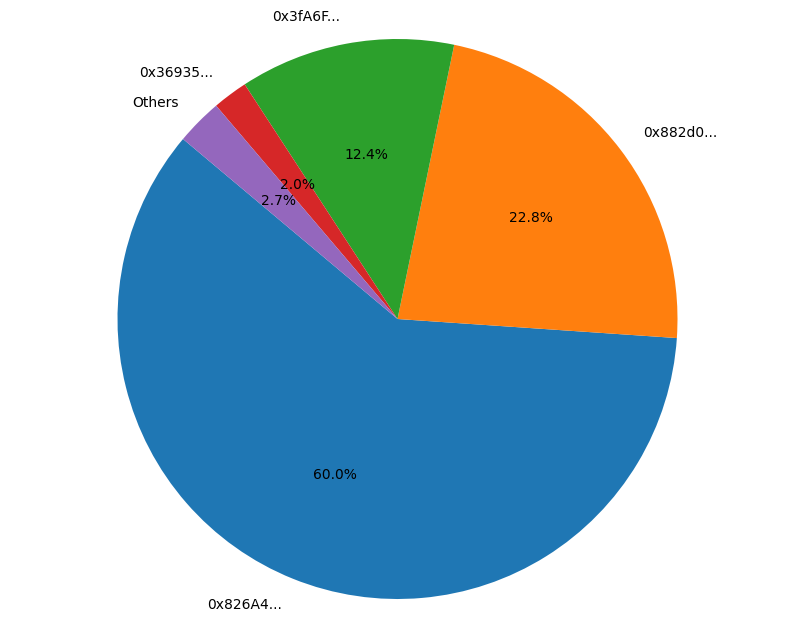

In [9]:
counter_ethereum = collections.Counter(
    extraction.ethereum_leg.searcher_contract_address
    for extraction in cross_chain_mev_extractions)
sorted_tokens = sorted(counter_ethereum.items(), key=lambda x: x[1], reverse=True)
threshold = 4
tokens = [f'{token[:7]}...' for token, _ in sorted_tokens]
counts = [count for _, count in sorted_tokens]
if len(tokens) > threshold:
    other_count = sum(count for count in counts[threshold:])
    tokens = tokens[:threshold] + ['Others']
    counts = counts[:threshold] + [other_count]
plt.figure(figsize=(10, 8))
plt.pie(counts, labels=tokens, autopct='%1.1f%%', startangle=140)
# plt.title('Searcher domination by number of arbitrages')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('searcher_domination_by_number.png')
plt.show()

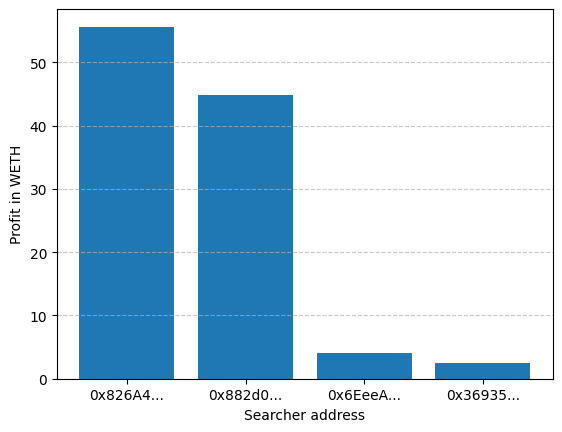

In [10]:
profit_dict_eth = collections.defaultdict(lambda: 0)
for extraction in cyclic_arbs:
    if extraction.profit_token_symbol == 'WETH':
        profit_dict_eth[extraction.ethereum_leg.searcher_contract_address] += float(extraction.profit_amount)
threshold = 4
sorted_tokens = sorted(profit_dict_eth.items(), key=lambda x: x[1], reverse=True)
tokens = [f'{token[:7]}...' for token, _ in sorted_tokens]
counts = [count for _, count in sorted_tokens]
if len(tokens) > threshold:
    tokens = tokens[:threshold] 
    counts = counts[:threshold]
plt.bar(tokens, counts)
plt.xlabel('Searcher address')
plt.ylabel('Profit in WETH')
# plt.title('Searcher domination by gross profit when using WETH')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('searcher_domination_by_profit_weth.png')
plt.show()

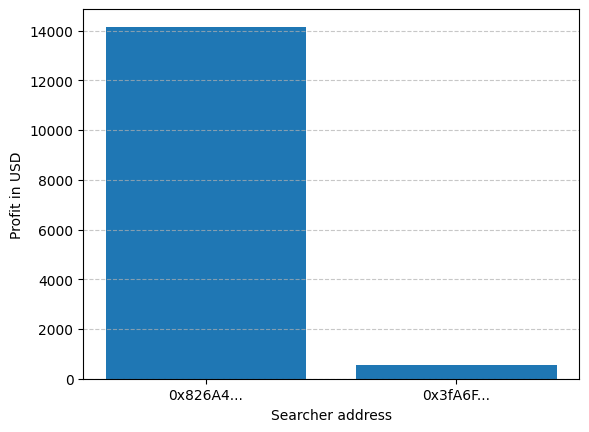

In [11]:
profit_dict_usd = collections.defaultdict(lambda: 0)
for extraction in cyclic_arbs:
    if extraction.profit_token_symbol == 'USDC' or extraction.profit_token_symbol == 'USDT':
        profit_dict_usd[extraction.ethereum_leg.searcher_contract_address] += float(extraction.profit_amount)
sorted_tokens = sorted(profit_dict_usd.items(), key=lambda x: x[1], reverse=True)
tokens = [f'{token[:7]}...' for token, _ in sorted_tokens]
counts = [count for _, count in sorted_tokens]
plt.bar(tokens, counts)
plt.xlabel('Searcher address')
plt.ylabel('Profit in USD')
# plt.title('Searcher domination by gross profit when using stable coin USD')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('searcher_domination_by_profit_usd.png')
plt.show()

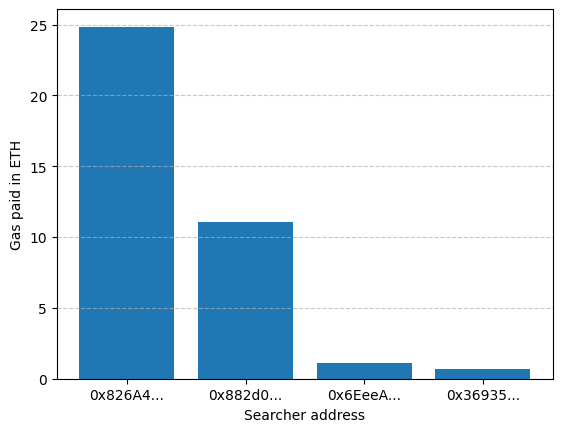

In [12]:
import web3

eth_gas_paid_dict = collections.defaultdict(lambda: 0)
for extraction in cyclic_arbs:
    gas_paid = extraction.ethereum_leg.gas_paid
    if gas_paid is not None:
        eth_gas_paid_dict[extraction.ethereum_leg.searcher_contract_address] += web3.Web3.from_wei(extraction.ethereum_leg.gas_paid, 'ether')


threshold = 4
sorted_tokens = sorted(eth_gas_paid_dict.items(), key=lambda x: x[1], reverse=True)
tokens = [f'{token[:7]}...' for token, _ in sorted_tokens]
counts = [count for _, count in sorted_tokens]
if len(tokens) > threshold:
    tokens = tokens[:threshold] 
    counts = counts[:threshold]
plt.bar(tokens, counts)
plt.xlabel('Searcher address')
plt.ylabel('Gas paid in ETH')
# plt.title('Searcher gas paid on Ethereum (for cyclic arbs)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('searcher_gas_paid_eth.png')
plt.show()

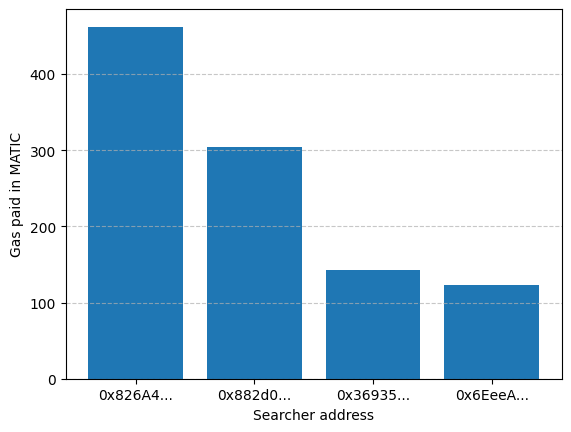

In [13]:
polygon_gas_paid_dict = collections.defaultdict(lambda: 0)
for extraction in cyclic_arbs:
    gas_paid = extraction.ethereum_leg.gas_paid
    if gas_paid is not None:
        polygon_gas_paid_dict[extraction.ethereum_leg.searcher_contract_address] += web3.Web3.from_wei(extraction.polygon_leg.swap_transaction_gas_paid, 'ether')


threshold = 4
sorted_tokens = sorted(polygon_gas_paid_dict.items(), key=lambda x: x[1], reverse=True)
tokens = [f'{token[:7]}...' for token, _ in sorted_tokens]
counts = [count for _, count in sorted_tokens]
if len(tokens) > threshold:
    tokens = tokens[:threshold] 
    counts = counts[:threshold]
plt.bar(tokens, counts)
plt.xlabel('Searcher address')
plt.ylabel('Gas paid in MATIC')
# plt.title('Searcher gas paid on Polygon (for cyclic arbs)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('searcher_gas_paid_polygon.png')
plt.show()

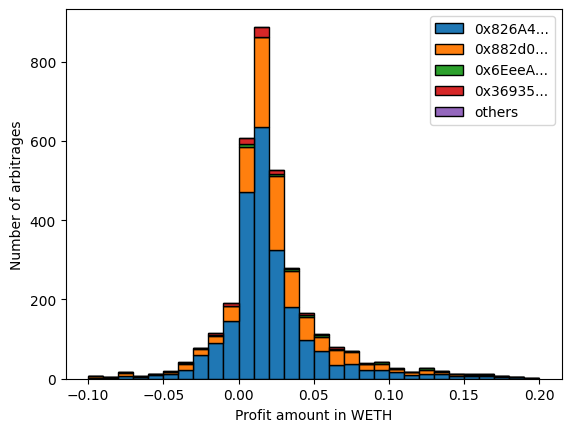

In [14]:
profit_dict_eth = collections.defaultdict(lambda: 0)
for extraction in cyclic_arbs:
    if extraction.profit_token_symbol == 'WETH':
        profit_dict_eth[extraction.ethereum_leg.searcher_contract_address] += float(extraction.profit_amount)
sorted_tokens = sorted(profit_dict_eth.items(), key=lambda x: x[1], reverse=True)
top_4_searchers = [searcher for searcher, _ in sorted_tokens][:4]
di = collections.defaultdict(lambda: [])
for extraction in cyclic_arbs:
    if extraction.profit_token_symbol == 'WETH':
        searcher = extraction.ethereum_leg.searcher_contract_address
        if searcher not in top_4_searchers:
            searcher = 'others'
        di[searcher].append(float(extraction.profit_amount))
list_to_plot = [di[searcher] for searcher in top_4_searchers]
list_to_plot.append(di['others'])
plt.hist(list_to_plot, bins=30, range=(-0.1, 0.2), label=[f'{s[:7]}...' for s in top_4_searchers] + ['others'], stacked=True, edgecolor = 'black')
plt.legend()
plt.xlabel('Profit amount in WETH')
plt.ylabel('Number of arbitrages')
plt.savefig('profit_per_tx_eth.png')
# plt.title('Side-by-Side Histogram with Multiple Searchers')
plt.show() 

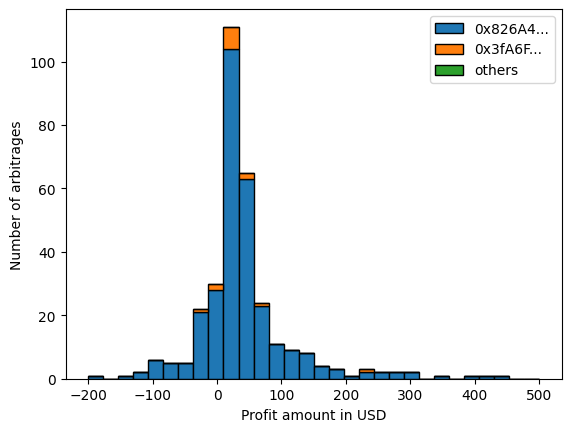

In [15]:
profit_dict_usd= collections.defaultdict(lambda: 0)
for extraction in cyclic_arbs:
    if extraction.profit_token_symbol == 'USDC' or extraction.profit_token_symbol == 'USDT':
        profit_dict_usd[extraction.ethereum_leg.searcher_contract_address] += float(extraction.profit_amount)
sorted_tokens = sorted(profit_dict_usd.items(), key=lambda x: x[1], reverse=True)
top_4_searchers = [searcher for searcher, _ in sorted_tokens][:4]
di = collections.defaultdict(lambda: [])
for extraction in cyclic_arbs:
    if extraction.profit_token_symbol == 'USDC' or extraction.profit_token_symbol == 'USDT':
        searcher = extraction.ethereum_leg.searcher_contract_address
        if searcher not in top_4_searchers:
            searcher = 'others'
        di[searcher].append(float(extraction.profit_amount))
list_to_plot = [di[searcher] for searcher in top_4_searchers]
list_to_plot.append(di['others'])
plt.hist(list_to_plot, bins=30, range=(-200, 500), label=[f'{s[:7]}...' for s in top_4_searchers] + ['others'], stacked=True, edgecolor = 'black')
plt.legend()
plt.xlabel('Profit amount in USD')
plt.ylabel('Number of arbitrages')
# plt.title('Side-by-Side Histogram with Multiple Searchers')
plt.savefig('profit_per_tx_usd.png')
plt.show() 

In [16]:
additional_info_ethereum = []
additional_info_polygon = []
for extraction in cross_chain_mev_extractions:
    additional_info_polygon.append(
        polygon_service.get_transaction_timestamp_and_gas_price(
            extraction.polygon_leg.swap_transaction_hash))
    additional_info_ethereum.append(
        ethereum_service.get_transaction_timestamp_and_gas_price(
            extraction.ethereum_leg.transaction_hash))

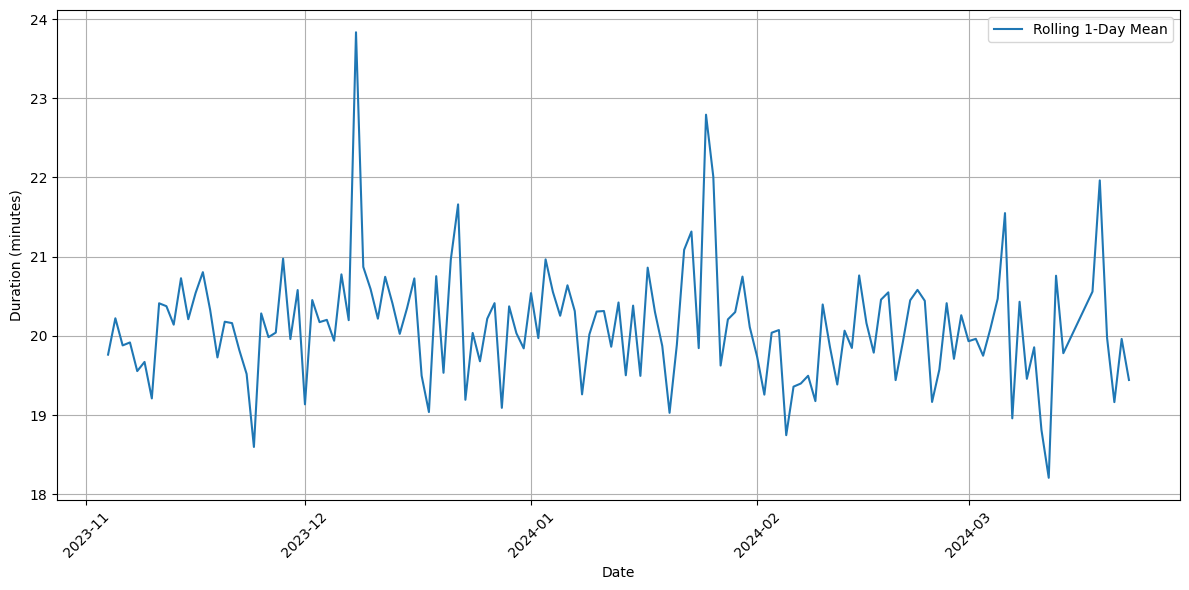

In [17]:
import pandas as pd

time_taken_for_arbitrage = {}
for i in range(len(cross_chain_mev_extractions)):
    if cross_chain_mev_extractions[i].direction is PolygonBridgeInteraction.FROM_ETHEREUM:
        time_taken_for_arbitrage[additional_info_ethereum[i][0]] = additional_info_polygon[i][0] - additional_info_ethereum[i][0]

timestamps = list(time_taken_for_arbitrage.keys())
durations = list(time_taken_for_arbitrage.values())
dates = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]

data = {'timestamp': timestamps, 'duration': durations}
df = pd.DataFrame(data)

# Set 'timestamp' column as datetime index
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('timestamp', inplace=True)

# Resample data to daily frequency and calculate the rolling mean over 1 day window
df_daily = df.resample('D').mean().rolling(window='1D').mean().dropna()
df_daily['duration_minutes'] = df_daily['duration'] / 60

# Plotting the data
plt.figure(figsize=(12, 6))

plt.plot(df_daily.index, df_daily['duration_minutes'], label='Rolling 1-Day Mean')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Duration (minutes)')
# plt.title('Arbitrage From Ethereum Durations Over Time (Rolling 1-Day Mean)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

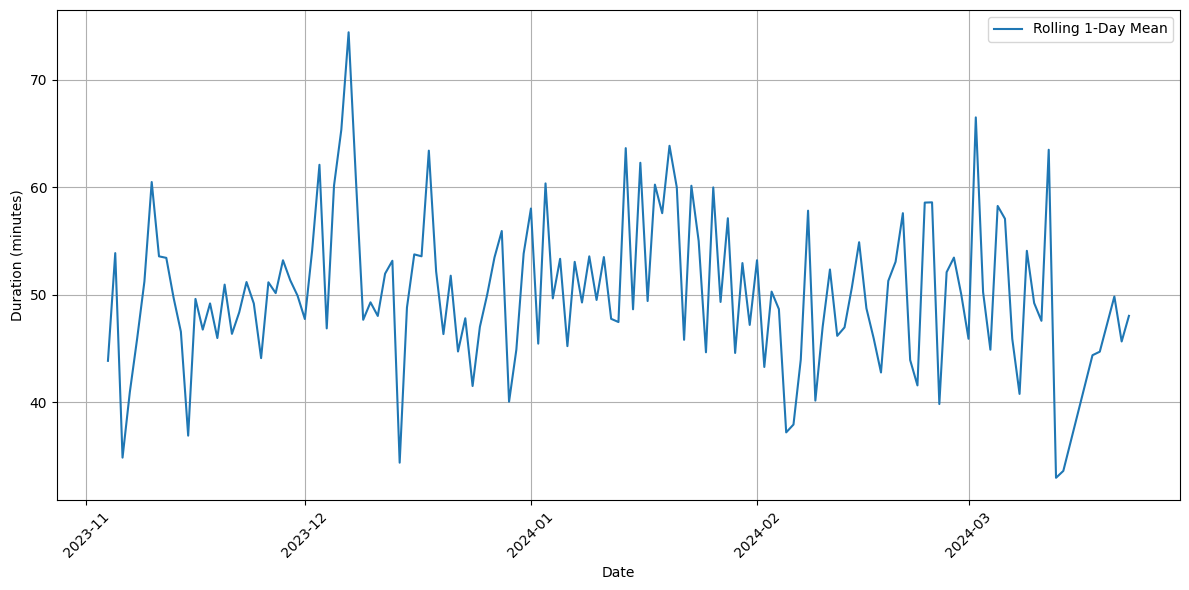

In [18]:
time_taken_for_arbitrage = {}
for i in range(len(cross_chain_mev_extractions)):
    if cross_chain_mev_extractions[i].direction is PolygonBridgeInteraction.TO_ETHEREUM:
        time_taken_for_arbitrage[additional_info_polygon[i][0]] = additional_info_ethereum[i][0] - additional_info_polygon[i][0]

timestamps = list(time_taken_for_arbitrage.keys())
durations = list(time_taken_for_arbitrage.values())

dates = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]

data = {'timestamp': timestamps, 'duration': durations}
df = pd.DataFrame(data)

# Set 'timestamp' column as datetime index
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('timestamp', inplace=True)

# Resample data to daily frequency and calculate the rolling mean over 1 day window
df_daily = df.resample('D').mean().rolling(window='1D').mean().dropna()
df_daily['duration_minutes'] = df_daily['duration'] / 60


# Plotting the data
plt.figure(figsize=(12, 6))

plt.plot(df_daily.index, df_daily['duration_minutes'], label='Rolling 1-Day Mean')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Duration (minutes)')
# plt.title('Arbitrage From Polygon Durations Over Time (Rolling 1-Day Mean)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

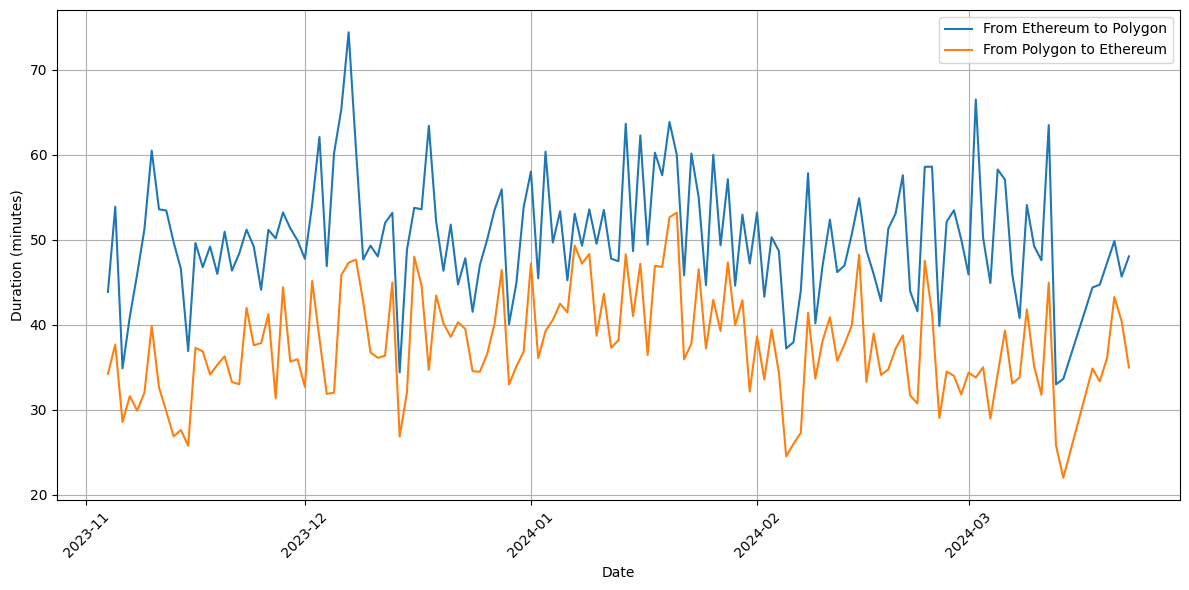

In [19]:
import pandas as pd

time_taken_for_arbitrage = {}
for i in range(len(cross_chain_mev_extractions)):
    if cross_chain_mev_extractions[i].direction is PolygonBridgeInteraction.FROM_ETHEREUM:
        time_taken_for_arbitrage[additional_info_ethereum[i][0]] = additional_info_polygon[i][0] - additional_info_ethereum[i][0]

timestamps = list(time_taken_for_arbitrage.keys())
durations = list(time_taken_for_arbitrage.values())
dates = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]

data = {'timestamp': timestamps, 'duration': durations}
df = pd.DataFrame(data)

# Set 'timestamp' column as datetime index
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('timestamp', inplace=True)

# Resample data to daily frequency and calculate the rolling mean over 1 day window
df_daily_ethereum = df.resample('D').mean().rolling(window='1D').mean().dropna()
df_daily_ethereum['duration_minutes'] = df_daily['duration'] / 60

for i in range(len(cross_chain_mev_extractions)):
    if cross_chain_mev_extractions[i].direction is PolygonBridgeInteraction.TO_ETHEREUM:
        time_taken_for_arbitrage[additional_info_polygon[i][0]] = additional_info_ethereum[i][0] - additional_info_polygon[i][0]

timestamps = list(time_taken_for_arbitrage.keys())
durations = list(time_taken_for_arbitrage.values())

dates = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]

data = {'timestamp': timestamps, 'duration': durations}
df = pd.DataFrame(data)

# Set 'timestamp' column as datetime index
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('timestamp', inplace=True)

# Resample data to daily frequency and calculate the rolling mean over 1 day window
df_daily_polygon = df.resample('D').mean().rolling(window='1D').mean().dropna()
df_daily_polygon['duration_minutes'] = df_daily_polygon['duration'] / 60

# Plotting the data together
plt.figure(figsize=(12, 6))

# Plotting Ethereum data
plt.plot(df_daily_ethereum.index, df_daily_ethereum['duration_minutes'], label='From Ethereum to Polygon')

# Plotting Polygon data
plt.plot(df_daily_polygon.index, df_daily_polygon['duration_minutes'], label='From Polygon to Ethereum')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Duration (minutes)')
# plt.title('Arbitrage Durations Over Time (Rolling 1-Day Mean)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.savefig('arbitrage_duration.png')
plt.show()


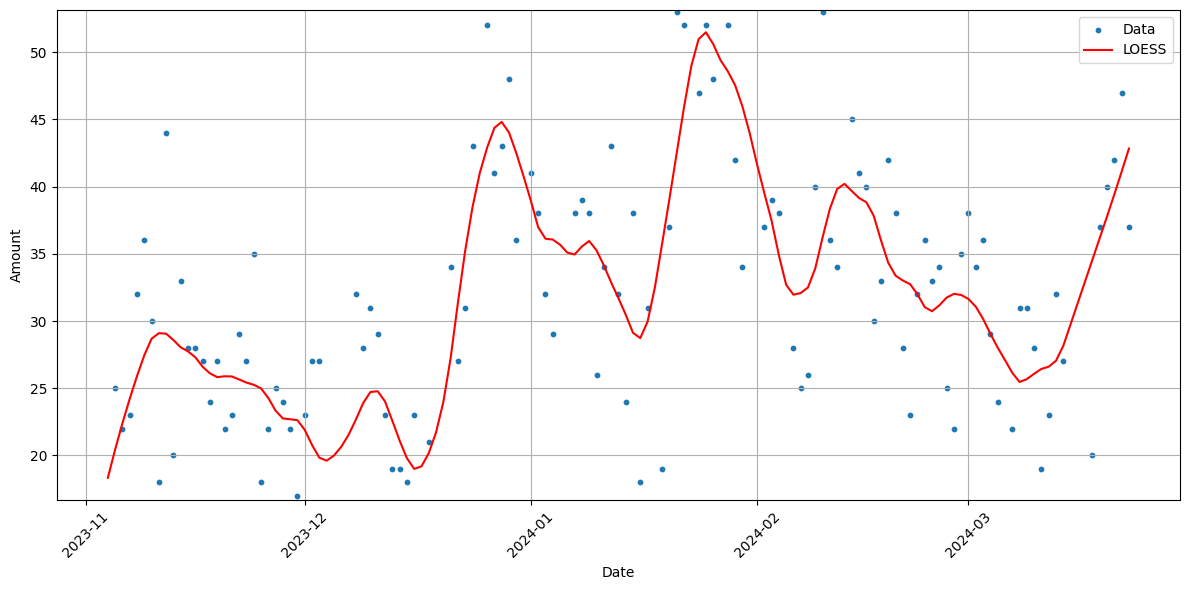

32.52173913043478


In [26]:
import datetime
import collections
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Assuming `cross_chain_mev_extractions` and `additional_info_ethereum` are defined appropriately

# Calculate direction_counter
direction_counter = collections.Counter(
    datetime.datetime.fromtimestamp(
        additional_info_ethereum[i][0]).date()
    for i in range(len(cross_chain_mev_extractions))
)

# Extract timestamps and durations from the Counter
timestamps = list(direction_counter.keys())
durations = list(direction_counter.values())

avg_durations_per_day = sum(durations) / len(durations)

# Convert timestamps to matplotlib-compatible format
mpl_dates = [plt.matplotlib.dates.date2num(date) for date in timestamps]

# Plotting the data as a scatter plot
plt.figure(figsize=(12, 6))  # Set figure size (width, height)
plt.scatter(timestamps, durations, marker='o', s=10, label='Data')  # Plotting as scatter plot

# Use statsmodels to fit a LOESS curve
lowess = sm.nonparametric.lowess
smoothed = lowess(durations, mpl_dates, frac=0.1)  # Adjust `frac` for smoother or rougher curve

# Plot LOESS line
plt.plot_date([plt.matplotlib.dates.num2date(point[0]) for point in smoothed],
              smoothed[:, 1], 'r-', label='LOESS')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Amount')
plt.xticks(rotation=45)
plt.grid(True)  # Show grid
plt.tight_layout()  # Adjust layout
# plt.title('Arbitrages Per Day with LOESS')
plt.legend()  # Show legend

# Save and display the plot
plt.savefig('arbitrages_per_day_with_loess.png')
plt.show()

print(avg_durations_per_day)